# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qlllllll/fire-risk-object-detection/blob/main/src/colab-demo.ipynb)

In [125]:
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd

warnings.filterwarnings("ignore")

GOOGLE_MAPS_API_KEY = ...

In [2]:
%load_ext autoreload
%autoreload 2

##### Loading GeoDataframe and Google Street View Images

In [3]:
from geo_utils import get_area_bbox, generate_network_pts, load_gsv_img_from_coords

# Define the area of interest
area = 'Hilgard Ave, Berkeley, CA'

# Retrieve the bounding box for the specified area
bbox = get_area_bbox(area, api_key=GOOGLE_MAPS_API_KEY)

# Generate sample points along the road network within the bounding box
sample_points = generate_network_pts(bbox, api_key=GOOGLE_MAPS_API_KEY, samp_dist=0.0001)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 649/649 [00:47<00:00, 13.66it/s]


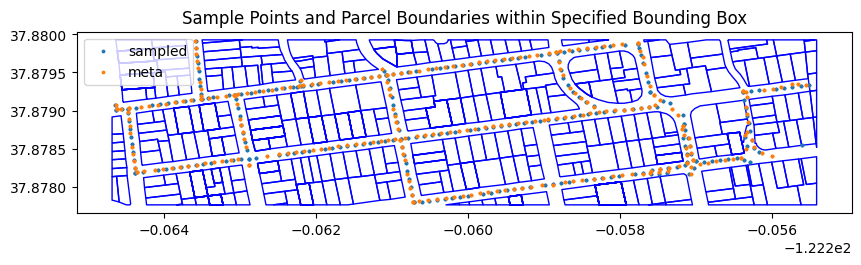

In [4]:
from geo_utils import load_parcels, clip_gdf_to_bbox

parcels = load_parcels()
bounded_gdf = clip_gdf_to_bbox(parcels, bbox)

fig, ax = plt.subplots(figsize=(10, 10))
bounded_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
sample_points.set_geometry('points').plot(ax=ax, markersize=3, label='sampled')
sample_points.set_geometry('meta_pt').plot(ax=ax, markersize=3, label='meta')
plt.legend()
plt.title("Sample Points and Parcel Boundaries within Specified Bounding Box")
plt.show()

##### Object Detection on Series of Images

In [ ]:
from object_detection_utils import load_images, depth_estimate, convert_depth_to_coords, object_grounded_segmentation, reformat_detections, generate_3d_bounding_boxes

# Load the first 100 images from the coordinates
images = load_gsv_img_from_coords(sample_points, api_key=GOOGLE_MAPS_API_KEY, save_dir='gsv_images')[:100]

# Estimate depth maps for the images
depth_maps = depth_estimate(images['image'])

# Project pixels onto a 3D plane
coords = convert_depth_to_coords(depth_maps)

# Perform object detection
detections = object_grounded_segmentation(images['image'], ['vegetation', 'house', 'fire hydrant'])

# Reformat detections into a dictionary grouped by label
re_detections = reformat_detections(detections)

# Estimate 3D bounding boxes for objects
re_detections['coords'] = generate_3d_bounding_boxes(re_detections, coords)

In [122]:
re_detections.head(5)

,img_idx,obj_idx,label,conf,box,mask,coords
0,0,0,house,0.6331,"[394, 253, 639, 365]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","((1.2719, -1.3979, 1.9361), (1.2719, -1.3979, ..."
1,0,1,house,0.4815,"[310, 261, 393, 335]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","((-0.1858, -1.9452, 2.9955), (-0.1858, -1.9452..."
2,0,0,vegetation,0.5742,"[466, 345, 639, 627]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","((1.1554, 0.2764, 0.765), (1.1554, 0.2764, 1.7..."
3,0,1,vegetation,0.3863,"[0, 32, 308, 320]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","((-3.4008, -5.449, 1.1949), (-3.4008, -5.449, ..."
4,0,2,vegetation,0.3575,"[246, 126, 375, 323]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","((-2.3165, -5.4442, 3.9357), (-2.3165, -5.4442..."


##### Geospatial Relationships between Objects

In [123]:
from object_detection_utils import dist, group_distances

# Calculate distances between vegetation and house coordinates.
distances = dist(re_detections[['label', 'img_idx', 'coords']], 'vegetation', 'house')

# Group the distances distances to house by applying a minimum threshold and filter.
dist_house_to_veg_min = group_distances(distances, re_detections, 'house', 'vegetation', fn=min)
dist_house_to_veg_min.head(2)

,img_idx,coords_house,coords_vegetation,distance,mask_house,box_house,conf_house,obj_idx_house,mask_vegetation,box_vegetation,conf_vegetation,obj_idx_vegetation
0,0,"((-0.1858, -1.9452, 2.9955), (-0.1858, -1.9452...","((-3.4008, -5.449, 1.1949), (-3.4008, -5.449, ...",0.218099,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[310, 261, 393, 335]",0.4815,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 32, 308, 320]",0.3863,1
1,0,"((1.2719, -1.3979, 1.9361), (1.2719, -1.3979, ...","((-3.4008, -5.449, 1.1949), (-3.4008, -5.449, ...",0.224890,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[394, 253, 639, 365]",0.6331,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 32, 308, 320]",0.3863,1


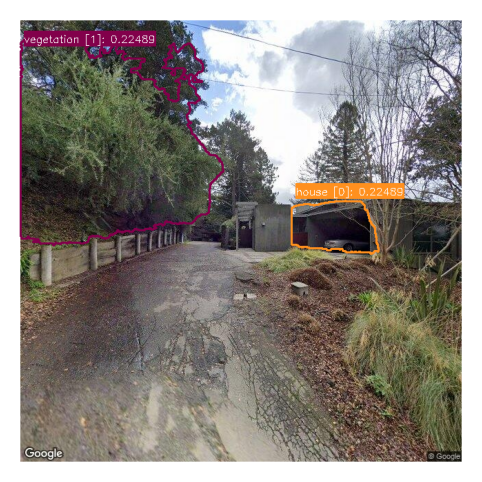

In [124]:
from plot_utils import *

# Plot the distance between first house and vegetation pair for the first image
annotate_mask_dist(images['image'], dist_house_to_veg_min, label1='house', label2='vegetation', img_idx=0, obj_idx=0) 

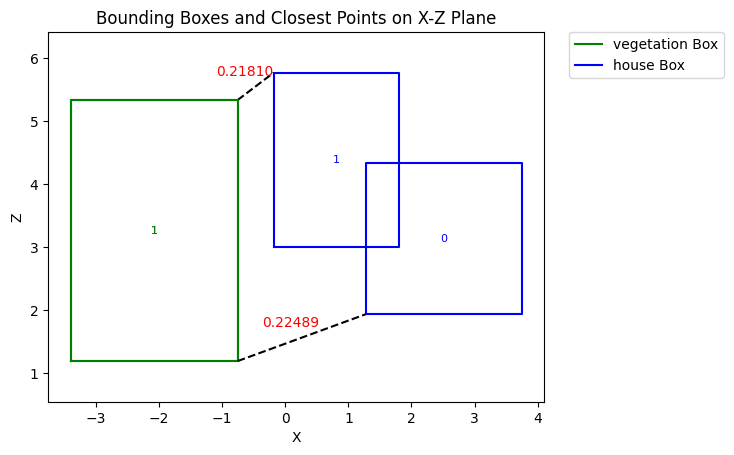

In [9]:
# Estimate the locations and plot the distance between vegetation and house for the image with index 0.
estimate_box(dist_house_to_veg_min, 0, 'vegetation', 'house')

,geometry,img_idx,obj_idx,label,conf,box,mask,coords,distance,meta_pt,perp_heading,image
0,POINT (-122.25720 37.87830),85.0,0.0,fire hydrant,0.8449,"[333, 459, 369, 520]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","((0.1287, 1.1937, 1.293), (0.1287, 1.1937, 1.4...",0.000044,POINT (-122.2572314178432 37.87826650963801),350,ImageFromAPI (./.images_from_api/gsv_images) : 85


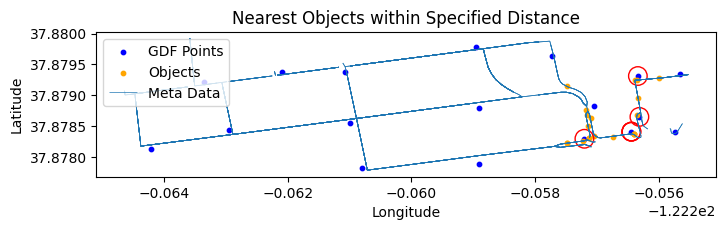

In [120]:
# Check if fire hydrants detected within max_dist from sample hydrants map
sample = gpd.read_file('data.geojson')
nearest_exist = nearest_object_existence(sample, re_detections[re_detections['label']=='fire hydrant'], meta=sample_points, images=images, max_dist=0.00015, visualize=True)
nearest_exist.head(1)

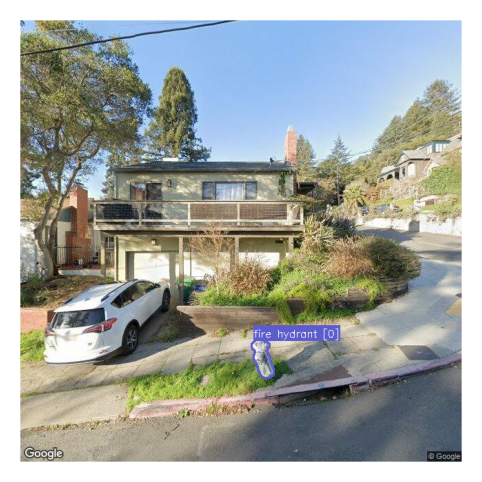

In [114]:
# Visualize the matching pair with annotation
annotate_mask_object(nearest_exist.iloc[0], 'fire hydrant')

In [116]:
#Find the nearest image to the sample hydrants map
nearest_image = nearest_image_existence(sample, images, max_dist=0.0001)
nearest_image.head(2)

,geometry,img_idx,perp_heading,image,distance
0,POINT (-122.25720 37.87830),84.0,170,ImageFromAPI (./.images_from_api/gsv_images) : 84,0.000044
0,POINT (-122.25720 37.87830),85.0,350,ImageFromAPI (./.images_from_api/gsv_images) : 85,0.000044


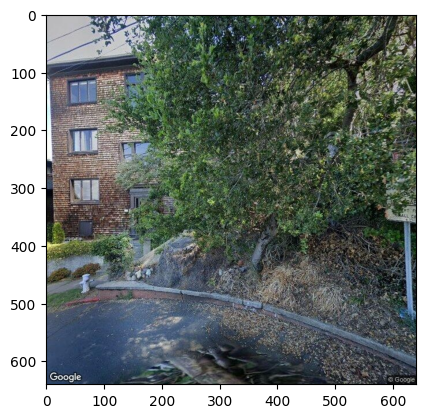

In [118]:
#Visualize one nearst image
plt.imshow(nearest_image['image'].iloc[2].image[:, :, ::-1]);

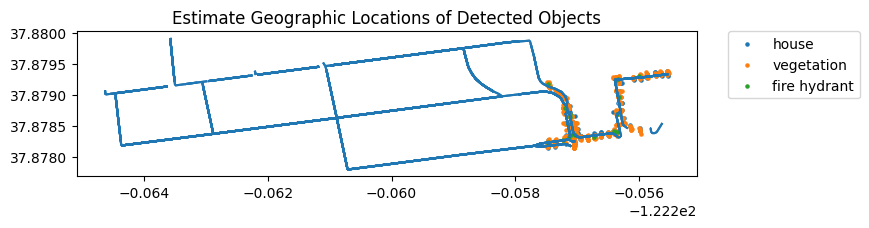

In [81]:
from object_detection_utils import estimate_object_locations

# Estimate geographic locations for the detected objects  
geoloc_results = estimate_object_locations(re_detections[['img_idx','coords', 'label']], meta=sample_points, visualize=True)

##### LazySeries Usage

In [11]:
from lazy_series import LazySeries, LazyDataFrame 
 
ls = LazySeries(images)
depth_maps = depth_estimate(ls)
detections = object_grounded_segmentation(ls, ['vegetation', 'house', 'fire hydrant'])
coords = convert_depth_to_coords(depth_maps)

In [12]:
detects = detections.iloc[0:5].show()
detects

0    [DetectionResult(score=0.6305191516876221, lab...
1    [DetectionResult(score=0.8343493938446045, lab...
2    [DetectionResult(score=0.762198269367218, labe...
3    [DetectionResult(score=0.7213582992553711, lab...
4    [DetectionResult(score=0.49029654264450073, la...
Name: gsv, dtype: object

In [13]:
detections

Value:
0    [DetectionResult(score=0.6305191516876221, lab...
1    [DetectionResult(score=0.8343493938446045, lab...
2    [DetectionResult(score=0.762198269367218, labe...
3    [DetectionResult(score=0.7213582992553711, lab...
4    [DetectionResult(score=0.49029654264450073, la...
5     ImageFromAPI (./.images_from_api/gsv_images) : 5
6     ImageFromAPI (./.images_from_api/gsv_images) : 6
7     ImageFromAPI (./.images_from_api/gsv_images) : 7
8     ImageFromAPI (./.images_from_api/gsv_images) : 8
9     ImageFromAPI (./.images_from_api/gsv_images) : 9
Name: gsv, dtype: object
Computation Graph: None -> <lambda>